# Bazični timeseries model korak po korak na airpassanger data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print ('\n Parsed Data:')
print (data.head())


 Parsed Data:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


<ipython-input-5-393b066b8c15>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


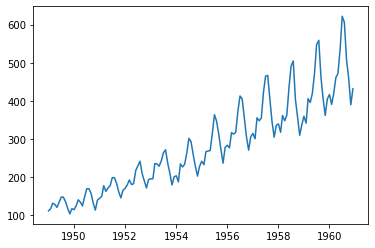

In [8]:

plt.plot(data)

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

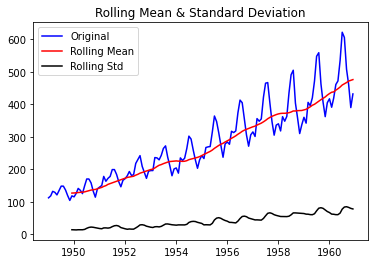

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
test_stationarity(data)

Na osnovu log transformacije nastojimo da detrendujemo seriju. Ali uspevamo da samo smanjimo
sve veće i veće razlike u rastu sezonskog efekta. 

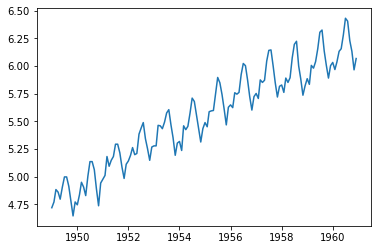

In [26]:
ts_log = np.log(data)
plt.plot(ts_log)

Pravimo pokretni prosek na osnovu 12 vremenskih tačaka (dvanaest meseci).

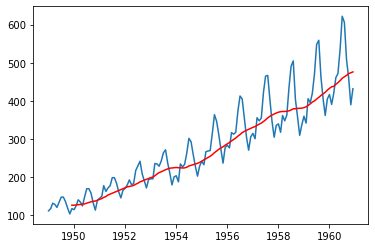

In [22]:
moving_avg = data.rolling(12).mean()
plt.plot(data)
plt.plot(moving_avg, color='red')

Pravimo moving_average sa log transformisanim podacima.

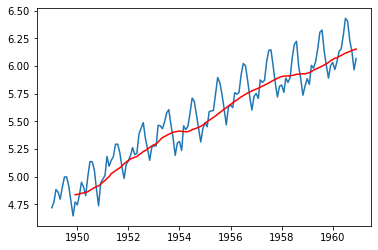

In [32]:
moving_avg_log = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg_log, color='red')

Pravimo i kvartalni pokretni prosek i dodajemo na plot i log transformaciju zelenom bojom.

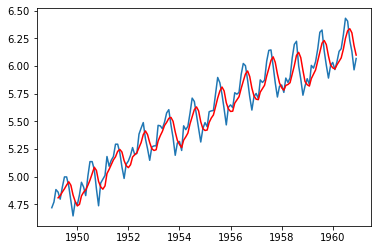

In [34]:
moving_avg_log_kvartal = ts_log.rolling(4).mean()
plt.plot(ts_log)
plt.plot(moving_avg_log_kvartal, color='red')

Oduzimamo seriju sa pokretnim prosecima od izvorne serije.

In [35]:
ts_log_moving_avg_diff = ts_log - moving_avg_log

Dobijamo da je serija sa pokretnim prosecima stacionarna.

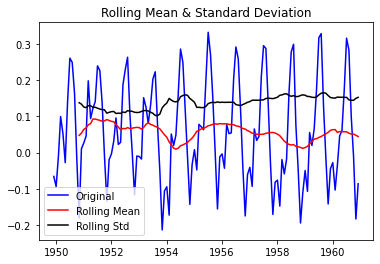

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [37]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Hoćemo da uradimo i eksponencijalni pokretni prosek serije jer vidimo da ne fituje dobro. 
Parametar alfa ukazuje na količinu zaglađivanja. Najmanje je ako je alfa=1.

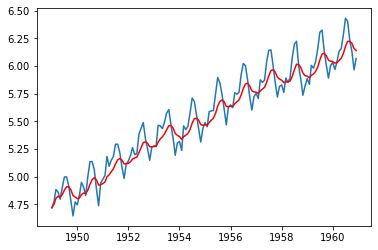

In [42]:
expwighted_avg = ts_log.ewm(alpha=0.2).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Oduzimamo od izvorne serije seriju sa eksponencijalnim prosekom da vidimo da li smo došli do stacionarnosti. Ovako smo došli do stabilnije stacionarnosti nego na prethodni način.

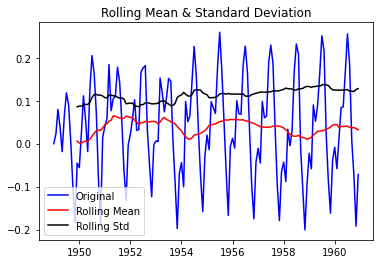

Results of Dickey-Fuller Test:
Test Statistic                  -3.210110
p-value                          0.019407
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [43]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Iz vremenske serije treba ukloniti i sezonalnost.Radimo prvo obično diferenciranje sa izvornom (log transformisanom) serijom. Trend je uklonjen.

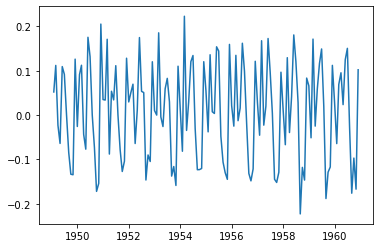

In [44]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

Proveravamo stacionarnost. Serija je nije stacionarna, ali je na granici. Stacionarna je sa 93% sigurnosti.

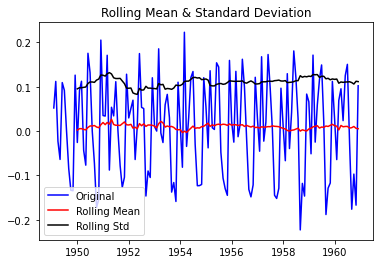

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [45]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Sledeći kod vrši detrendovanje i desezoniranje vremenske serije.
Modul seasonal_decompose u sebi sadrži 

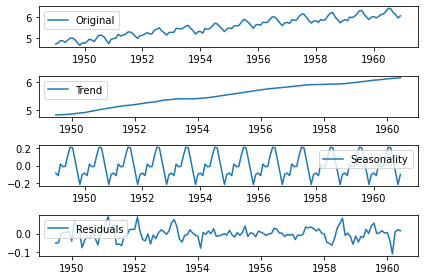

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Ovde možemo videti da su trend, sezonalnost odvojeni od podataka i sada možemo modelirati reziduale. Proverimo stacionarnost reziduala:

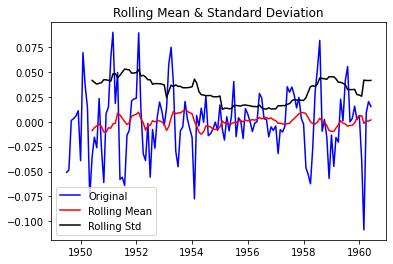

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [52]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Forecasting

ARIMA je skraćenica od Autoregresija integrisanih pokretnih proseka. 
ARIMA predviđanje se koristi za stacionarne vremenske serije i nije ništa drugo do linearna (poput linearne regresije) jednačina. Prediktori zavise od parametara (p, d, k) ARIMA modela:

Broj parametara AR (auto-regresivnih) lagova (p): AR pojmovi su samo zaostajanja zavisne promenljive, odnosno vremenski periodi. Na primer, ako je p 5, prediktori za k (t) biće k (t-1)…(t-5).

Broj parametara MA (pokretni prosek) (k): Parametar MA  koristi k grešaka prognoze u jednačini predviđanja. Na primer, ako je k 5, prediktori za k (t) biće e (t-1)…e(t-5) gde je e (i) razlika između pokretnog proseka u trenutku t i stvarne vrednosti.

Broj parametara diferenciranja (d): Ovo je broj nesezonskih razlika, tj. U ovom slučaju smo uzeli razliku prvog reda. To je broj koji nam govori koliko puta oduzimamo vremensku seriju Xt od Xt-1.

Funkcija autokorelacije (ACF): To je mera korelacije između TS-a u trenutku t Xt i X(t-1). Na primer, u zaostajanju od 5, ACF bi uporedio serije u trenutku „t1“… „t2“ sa serijama u trenutku „t1-5“… „t2-5“ (t1-5 i t2 su krajnje tačke).

Funkcija parcijalne autokorelacije (PACF): Ovim se meri korelacija između TS-a sa zaostalom verzijom same sebe, ali nakon uklanjanja varijacija koje su već objašnjene međupoređenjima. Npr. U zaostajanju 5, proveriće korelaciju, ali ukloniti efekte koji su već objašnjeni zaostancima 1 do 4.
Grafikoni ACF i PACF za TS nakon diferencijacije mogu se prikazati kao:

In [55]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [61]:
lag_acf = acf(ts_log_diff, nlags=40)
lag_pacf = pacf(ts_log_diff, nlags=40, method='ols')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

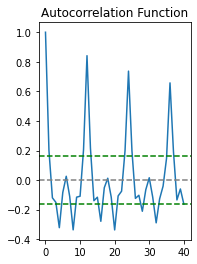

In [62]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

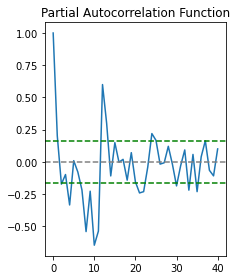

In [63]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Na ovim grafikonima dve isprekidane crte s obe strane 0 su intervali poverenja. Oni se mogu koristiti za određivanje vrednosti „p“ i „k“ kao:

p - Vrednost zaostajanja gde PACF grafikon prvi put prelazi gornji interval pouzdanosti. Ako pažljivo primetite, u ovom slučaju p = 2.
k - Vrednost zaostajanja gde ACF grafikon prvi put prelazi gornji interval pouzdanosti. Ako pažljivo primetite, u ovom slučaju k = 2.
Sada, napravimo 3 različita ARIMA modela uzimajući u obzir pojedinačne kao i kombinovane efekte. Takođe ću odštampati RSS za svaku. Imajte na umu da se ovde RSS odnosi na vrednosti ostataka, a ne na stvarne serije.

In [64]:
from statsmodels.tsa.arima_model import ARIMA

AR model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


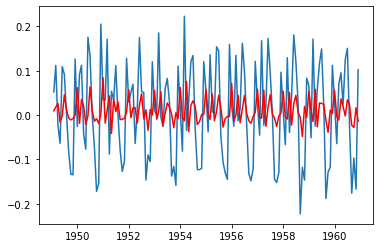

In [100]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [158]:
RSS_AR=np.sqrt(sum((results_AR.fittedvalues.to_numpy().reshape(143,1)-ts_log_diff.to_numpy())**2))

In [157]:
RSS_AR

array([1.22568486])

MA model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


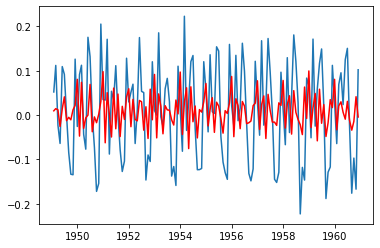

In [111]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [159]:
RSS_MA=np.sqrt(sum((results_MA.fittedvalues.to_numpy().reshape(143,1)-ts_log_diff.to_numpy())**2))

Kombinovani model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


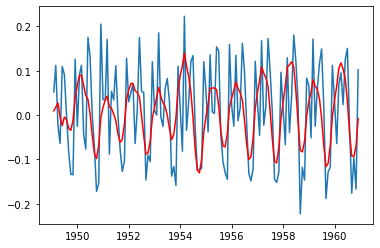

In [114]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [162]:
RSS_ARIMA=np.sqrt(sum((results_ARIMA.fittedvalues.to_numpy().reshape(143,1)-ts_log_diff.to_numpy())**2))

Vidimo da je kombinovani model najbolji, ima najmanju grešku predviđanja.

In [166]:
print("\n",'Greška (RSS) AR modela:',RSS_AR, "\n", 
      'Greška (RSS) MA modela:',RSS_MA, "\n", 
      'Greška (RSS) ARIMA kombinovanog modela:',RSS_ARIMA, "\n")


 Greška (RSS) AR modela: [1.22568486] 
 Greška (RSS) MA modela: [1.21331782] 
 Greška (RSS) ARIMA kombinovanog modela: [1.0144713] 



In [167]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

Primetite da ovi počinju od „1949-02-01“, a ne prvog meseca. Zašto? To je zato što smo napravili zaostatak za 1, a prvi element nema od čega da se oduzme. Način za pretvaranje razlike u skal je dodavanje ovih razlika uzastopno osnovnom broju. Jednostavan način da to uradite je da prvo odredite kumulativni zbir po indeksu, a zatim ga dodate osnovnom broju. Zbirni zbir može se naći kao:

In [170]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [171]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01         NaN
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
dtype: float64

In [180]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[:,0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.780265
1949-03-01    4.909873
1949-04-01    4.914554
1949-05-01    4.846011
dtype: float64

In [192]:
data['#Passengers'].mean()

280.2986111111111

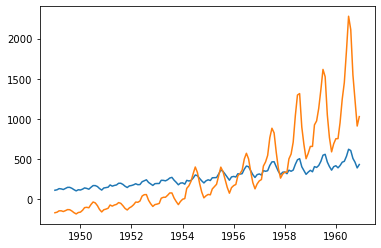

In [194]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA-280)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [184]:
predictions_ARIMA_vita = np.exp(results_ARIMA.fittedvalues.to_numpy().reshape(143,1))

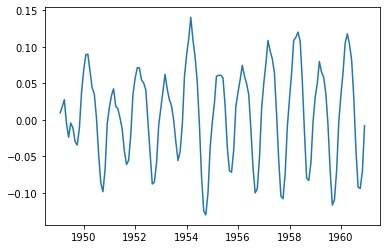

In [188]:
plt.plot(results_ARIMA.fittedvalues)